In [1]:
import pandas as pd
import numpy as np
from haversine import haversine, haversine_vector, Unit
import geopandas as gpd
import matplotlib.pyplot as plt
import cma

In [2]:
# To supress the scientific notation for easier reading.
np.set_printoptions(suppress=True)

# Test Development

In developing the code, three main tests have been completed within one region: Amhara. The first at a very micro level with a custom dummy dataset with only two primary schools and 2 proposed secondary schools. The second is for one woreda/district with 21 primary schools and two secondary schools, whereby 5 secondary schools are proposed. The final test was a region wide test with 1765 primary schools and 1658 secondary schools, with 5 new secondary schools proposed.

In [3]:
# Specify which test to perform
declare_test = 2 # micro test

In [4]:
# Declare key variables according to the test being performed.
region = 'Amhara' # Test Amhara region
woreda = 'ET030908'

if declare_test == 1: # for micro test
    # read in the prepared dataset. Evaluate point data to make it readible by geopandas
    df = pd.read_csv('data/test_dataset2.csv', converters={'point': pd.eval})
    proposed_schools= 2
    gdf_woreda = gpd.read_file('eth_shape_files/json/eth_admin3v2.json')
    gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
    df = df.loc[df['ADM3_PCODE'] == woreda]
    bounds = gdf_woreda_shp.bounds
elif declare_test == 2:
    df = pd.read_csv('data/test_dataset.csv', converters={'point': pd.eval})
    proposed_schools= 5
    gdf_woreda = gpd.read_file('eth_shape_files/json/eth_admin3v2.json')
    gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
    df = df.loc[df['ADM3_PCODE'] == woreda]
    bounds = gdf_woreda_shp.bounds
else:
    proposed_schools= 5
    df = pd.read_csv('data/clean_dataset.csv', converters={'point': pd.eval})
    # limit geojson to only selected region
    # limit clean dataset to only selected region
    gdf_region = gpd.read_file('eth_shape_files/json//eth_admin1v2.json') # read in geojson
    gdf_region_shp = gdf_region.loc[gdf_region['ADM1_EN']==region]['geometry'].reset_index(drop=True)
    df = df.loc[df['region'] == region]
    bounds = gdf_region_shp.bounds 

## Data Preparation

In [5]:
# Establish boundaries based on the bounds of region or woreda.
# Latitude is the Y axis, longitude is the X axis.

lat_bounds = bounds[['miny','maxy']].to_numpy(dtype=float)[0]
lon_bounds = bounds[['minx','maxx']].to_numpy(dtype=float)[0]
bounds = np.array([[lat_bounds[0], lon_bounds[0]], [lat_bounds[1], lon_bounds[1]]])
# array - [[lower lat bounds, lower lon bounds],[upper lat bounds, upper lon bounds]]
# CMA expects a list of size 2 for bounds
x1y1 = np.repeat([bounds[0,:]],proposed_schools, axis=0).flatten()
x2y2 = np.repeat([bounds[1,:]],proposed_schools, axis=0).flatten()
boundsxy = [x1y1,x2y2]
boundsxy

[array([10.71371939, 36.68932805, 10.71371939, 36.68932805]),
 array([10.96477258, 36.96973029, 10.96477258, 36.96973029])]

In [6]:
# Create subset arrays required as input for enrollment function.
# 1. Primary school enrollment data
# 2. Primary school location data: lat lon point data. 
# 3. Secondary schoool location data: lat lon point data. 
# 4. Secondary school enrollment data. Potentially required for calibration function.

df_prim = df.loc[ (df['gr_offer'] == 'G.1-8') | (df['gr_offer'] == 'G.5-8')]
df_prim_enroll = df_prim['grade5_8'].reset_index(drop=True).to_numpy(dtype=float)
df_prim_loc = df_prim['point'].reset_index(drop=True).to_numpy()
df_prim_loc = np.array([np.array(i) for i in df_prim_loc], dtype=float)

df_sec = df.loc[ (df['gr_offer'] == 'G. 9-10') | (df['gr_offer'] == 'G. 9-12')]
df_sec_loc = df_sec['point'].reset_index(drop=True).to_numpy()
df_sec_enroll = df_sec['grade9_10'].reset_index(drop=True).to_numpy(dtype=float)
df_sec_loc = np.array([np.array(i) for i in df_sec_loc], dtype=float)

## Key functions

In [7]:
def check_woreda(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_woreda_shp[0]).all()
            
def check_region(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_region_shp[0]).all()

In [118]:
def shape(distance, enrollment):
    min_walk = 2 # distance not a factor issuing enrollment until 2km
    max_walk = 5 # distance greater than 5km assumes zero enrollment
    answer = np.where(distance<min_walk, enrollment,
             np.where(distance>max_walk, 0,
                     enrollment*(1-(distance-min_walk)/(max_walk-min_walk)))
            )
    return answer

In [119]:
shape(2.4, 100)

array(86.66666667)

In [9]:
# To be user later on as an alternative method. 
# def weighted_travel_time(prim_loc, x, prim_enroll, sec_loc):
#     x = np.append(sec_loc, x) # The genotype
#     x = np.array(np.array_split(x, (len(sec_loc)+proposed_schools)))
#     distance = haversine_vector(prim_loc, x, Unit.KILOMETERS, comb=True)
#     min_d = np.min(distance, axis=0) # array with minimum distance from each primacy school to every secondary.
#     return np.sum(min_d*prim_enroll)

In [10]:
def expected_enroll(prim_loc, x, prim_enroll, sec_loc):
    
#     x = np.append(sec_loc, x) # The genotype
#     x = np.array(np.array_split(x, (len(sec_loc)+proposed_schools)))
    distance = haversine_vector(prim_loc, x, Unit.KILOMETERS, comb=True)
    min_d = np.min(distance, axis=0) # array with minimum distance from each primacy school to every secondary.
    shaped_enroll = shape(min_d, prim_enroll)
    return np.sum(shaped_enroll)

In [127]:
np.sum(df_prim_enroll)

30000.0

In [122]:
x =  get_random_sp()
x = np.array(np.array_split(x, (len(df_sec_loc)+proposed_schools)))
x

array([[10.87906874, 36.7459008 ],
       [10.85640989, 36.88513192]])

In [123]:
df_prim_loc

array([[10.7806, 36.9441],
       [10.794 , 36.9308]])

In [11]:
# # The Objective Function
# def f(x):

#     test_case = expected_enroll(df_prim_loc, x, df_prim_enroll)
#     return test_case
                    
# don't do the rounding here. 

In [12]:
# The Objective Function with the shape function included.
def f2(x):
    x = np.append(df_sec_loc, x) # The genotype
    x = np.array(np.array_split(x, (len(df_sec_loc)+proposed_schools))) # reshape!
    test_case = expected_enroll2(df_prim_loc, x, df_prim_enroll, df_sec_loc)
    return test_case

In [13]:
# Create starting points within regional box boundaries.

def create_random_sp():
    sp1 = np.random.uniform(low=lat_bounds[0], high=lat_bounds[1], size=proposed_schools)
    sp2 = np.random.uniform(low=lon_bounds[0], high=lon_bounds[1], size=proposed_schools)
    sp = np.vstack((sp1, sp2)).T
    return sp

# create a random starting point within the target region.
def get_random_sp():
    sp = create_random_sp()
    for i in range(0,10000):
        if declare_test == 3:
            if check_region(sp) == True:
                return sp.flatten()
                break
            else:
                sp = create_random_sp()
        else:
            if check_woreda(sp) == True:
                return sp.flatten()
                break
            else:
                sp = create_random_sp()

## Random Search

In [14]:
def random_search(f, n):
    x = [get_random_sp() for _ in range(n)] 
    fx = [(f(xi), xi) for xi in x]
    best_f, best_solution = min(fx, key=lambda x:x[0])
    return best_f, best_solution

In [15]:
fx = [random_search(f, 10000) for _ in range(4)]

In [128]:
fx

[(12204.895, array([10.78273461, 36.94598938, 10.78896181, 36.93253535])),
 (22089.102, array([10.78108612, 36.94311093, 10.7937701 , 36.77857652])),
 (20285.563, array([10.78746633, 36.94004147, 10.77884434, 36.94098348])),
 (21736.144, array([10.89867579, 36.88180811, 10.78090569, 36.94439602]))]

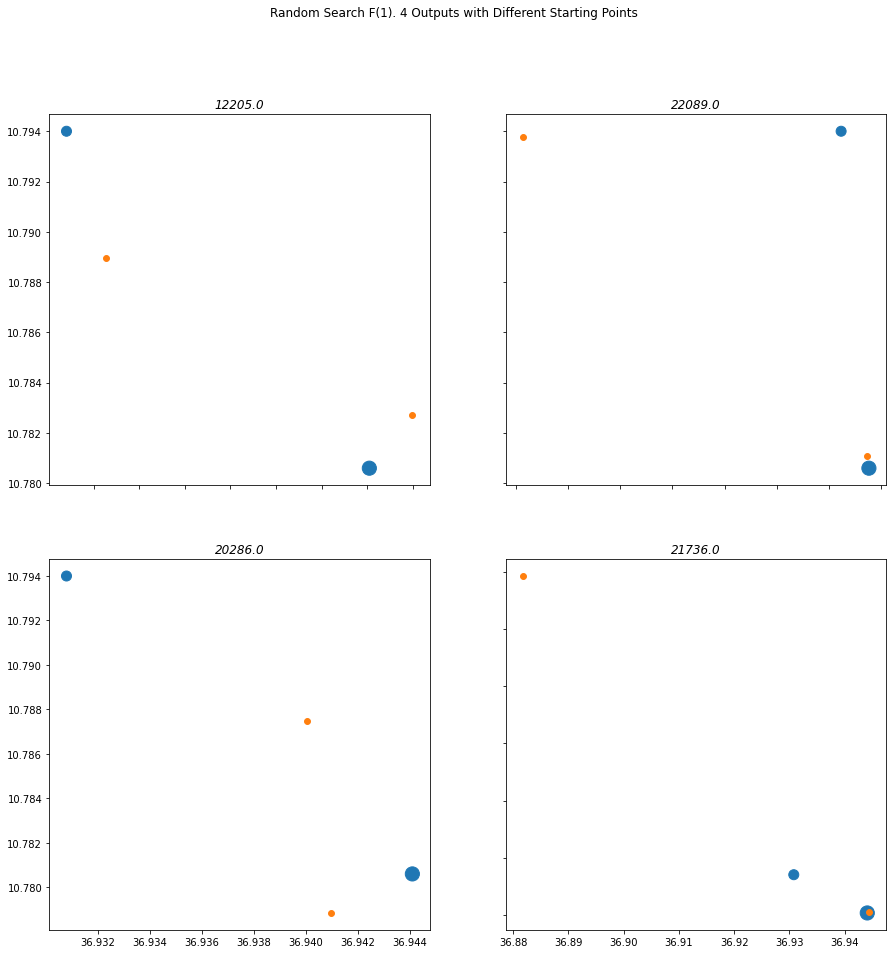

In [16]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Random Search F(1). 4 Outputs with Different Starting Points')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter(fx[i][1][1::2], fx[i][1][::2], s = 35, marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title(np.round(fx[i][0],0), fontstyle='italic')

for ax in fig.get_axes():
    ax.label_outer()

In [17]:
fx2 = [random_search(f2, 10000) for _ in range(4)]

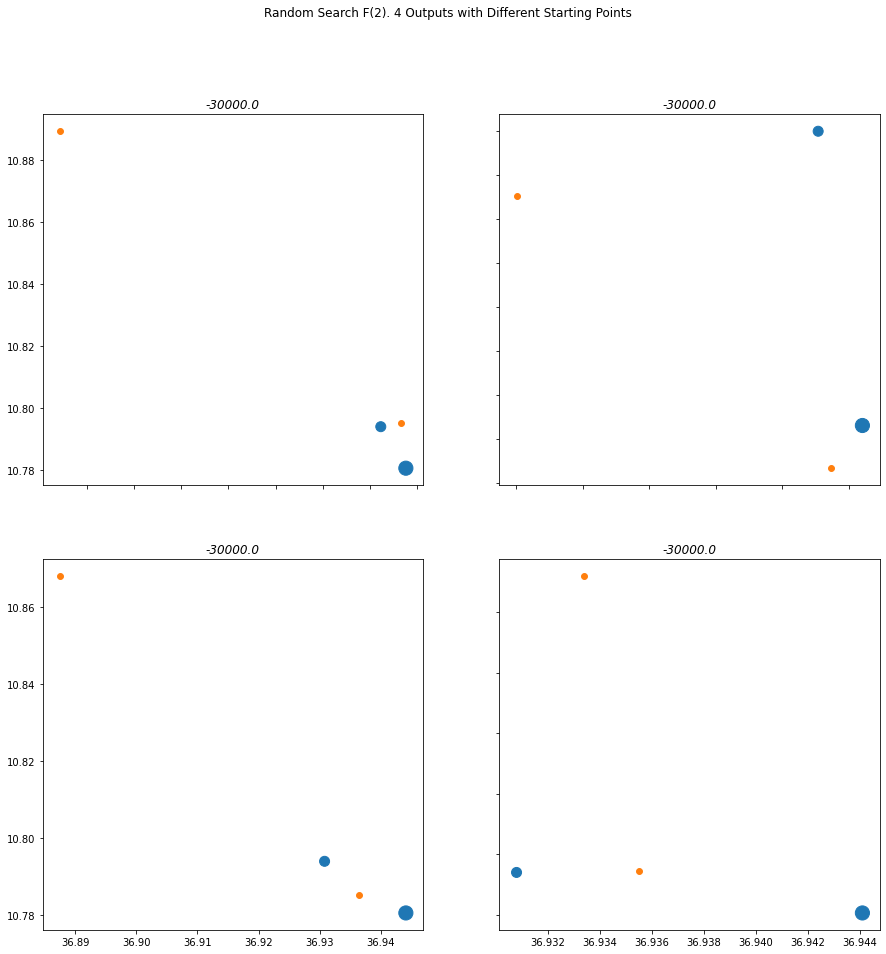

In [18]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Random Search F(2). 4 Outputs with Different Starting Points')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter(fx2[i][1][1::2], fx2[i][1][::2], s = 35, marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title(np.round(fx2[i][0],0), fontstyle='italic')

for ax in fig.get_axes():
    ax.label_outer()

## CMA

In [19]:
sigmas = (0.01, 0.05, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24)
maxits = 10000

In [129]:
get_random_sp()

array([10.8626972 , 36.77992452, 10.80562356, 36.93367708])

In [20]:
fcma = []

for i in range(4):
    for j in sigmas:
        es = cma.CMAEvolutionStrategy(get_random_sp(), sigma0=j,
                                  inopts={'bounds': boundsxy,'seed':1234})
        es.optimize(f, iterations=maxits / es.popsize)
        fcma.append((es.result[1], es.result[0], j))
        
fcma_s = sorted(fcma, key=lambda t: t[0])[:4]

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Fri Jul  1 09:39:49 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 7.461673299999999e+04 1.0e+00 1.06e-02  1e-02  1e-02 0:00.0
    2     16 5.737463100000000e+04 1.6e+00 1.21e-02  1e-02  1e-02 0:00.0
    3     24 4.651914300000000e+04 1.9e+00 1.21e-02  1e-02  1e-02 0:00.0
  100    800 2.081022900000000e+04 4.3e+03 6.81e-06  3e-09  1e-05 0:00.3
NOTE (module=cma, iteration=106):  
condition in coordinate system exceeded 1.3e+08, rescaled to 1.0e+00, 
condition changed from 1.2e+08 to 1.9e+01
  113    904 2.081022800000000e+04 3.5e+00 4.60e-06  8e-10  1e-05 0:00.4
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Fri Jul  1 09:39:50 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.821597550000000e+05 1.0e+00 3.94e-02  4e-02  4e-02 0:00.0
    2     16 1.613340210000000e+05 1.3e+00 4.14e-02  4e-02  4e-02 0:00.0
    3     24 7.76547

    2     16 3.870675500000000e+04 1.5e+00 1.12e-01  1e-01  1e-01 0:00.0
    3     24 5.013752600000000e+04 1.6e+00 1.04e-01  9e-02  1e-01 0:00.0
  100    800 2.081025000000000e+04 1.9e+03 5.86e-05  3e-08  6e-05 0:00.3
NOTE (module=cma, iteration=115):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 1.3e+08 to 7.0e+00
  152   1216 2.081022700000000e+04 2.5e+01 5.88e-06  1e-10  1e-05 0:00.4
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Fri Jul  1 09:40:00 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 7.618372199999999e+04 1.0e+00 1.15e-01  1e-01  1e-01 0:00.0
    2     16 7.461502000000000e+04 1.2e+00 1.07e-01  9e-02  1e-01 0:00.0
    3     24 7.502224700000000e+04 1.3e+00 1.07e-01  9e-02  1e-01 0:00.0
  100    800 2.081024100000000e+04 2.4e+03 1.69e-05  1e-08  2e-05 0:00.3
NOTE (module=cma, iteration=111):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 


  166   1328 2.081022700000000e+04 2.6e+02 2.70e-05  2e-10  3e-04 0:00.5
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Fri Jul  1 09:40:10 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 6.182713700000000e+04 1.0e+00 1.38e-01  1e-01  1e-01 0:00.0
    2     16 8.583162800000000e+04 1.2e+00 1.39e-01  1e-01  2e-01 0:00.0
    3     24 3.636634100000000e+04 1.7e+00 1.66e-01  1e-01  2e-01 0:00.0
  100    800 2.272000000000000e+00 2.4e+00 3.74e-05  7e-07  2e-06 0:00.3
  173   1384 0.000000000000000e+00 5.0e+00 5.16e-08  4e-11  2e-10 0:00.6
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Fri Jul  1 09:40:11 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 7.769043200000000e+04 1.0e+00 1.64e-01  2e-01  2e-01 0:00.0
    2     16 7.904448699999999e+04 1.2e+00 1.49e-01  1e-01  2e-01 0:00.0
    3     24 1.104779200000000e+05 1.5e+00 1.42e-01  1e-01  2e-01 0:00.0
  100    800 2.08102390

  145   1160 2.081022700000000e+04 9.0e+00 5.11e-06  2e-10  9e-06 0:00.5
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Fri Jul  1 09:40:20 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.393625560000000e+05 1.0e+00 1.84e-01  2e-01  2e-01 0:00.0
    2     16 1.461504470000000e+05 1.2e+00 1.58e-01  1e-01  2e-01 0:00.0
    3     24 1.058206440000000e+05 1.6e+00 1.69e-01  1e-01  2e-01 0:00.0
  100    800 2.081100000000000e+04 1.0e+03 7.59e-04  1e-06  9e-04 0:00.4
NOTE (module=cma, iteration=128):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 1.6e+08 to 8.2e+00
  177   1416 2.081022700000000e+04 4.9e+01 2.50e-05  2e-10  7e-05 0:00.6


In [21]:
fcma_s

[(0.0, array([10.7806, 36.9441, 10.794 , 36.9308]), 0.12),
 (0.0, array([10.7806, 36.9441, 10.794 , 36.9308]), 0.2),
 (0.0, array([10.794 , 36.9308, 10.7806, 36.9441]), 0.24),
 (0.0, array([10.794 , 36.9308, 10.7806, 36.9441]), 0.05)]

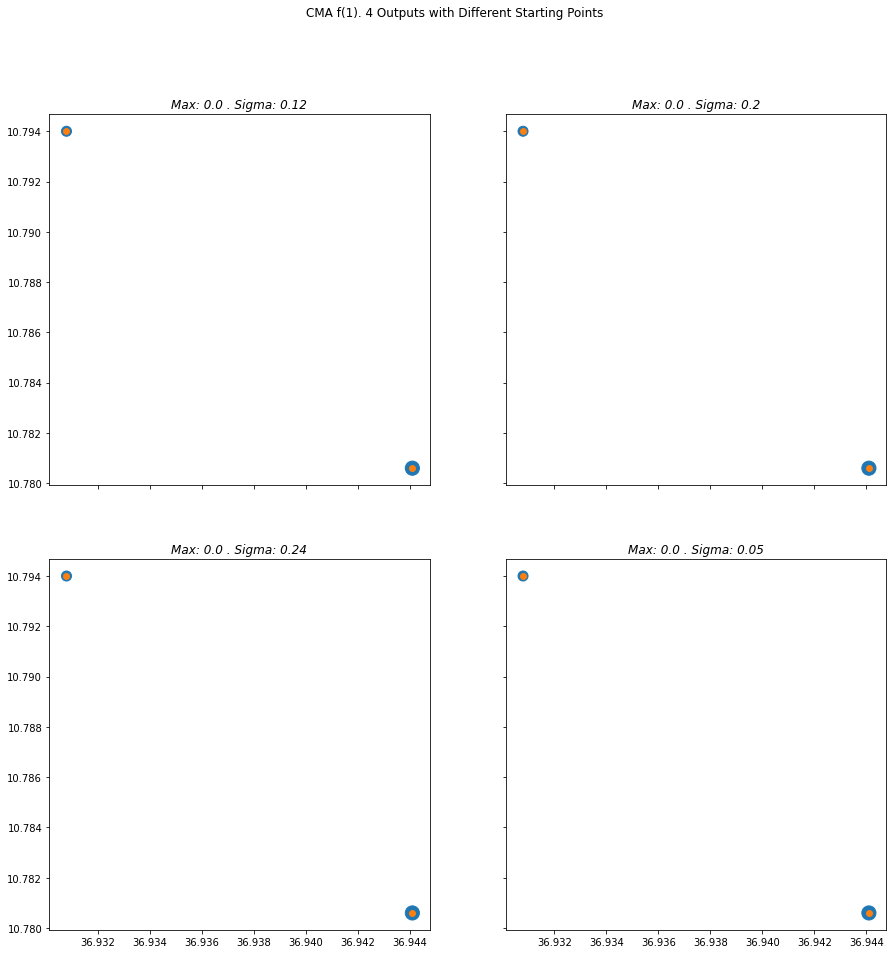

In [22]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('CMA f(1). 4 Outputs with Different Starting Points')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter(fcma_s[i][1][1::2], fcma_s[i][1][::2], s = 35, marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title('Max: ' + str(np.round(fcma_s[i][0],0))+ ' . Sigma: ' + str(fcma_s[i][2]), fontstyle='italic')

for ax in fig.get_axes():
    ax.label_outer()

In [130]:
get_random_sp()

array([10.91022766, 36.863956  , 10.8897969 , 36.82775777])

In [23]:
fcma2 = []
maxits= 10000

for i in range(4):
    for j in sigmas:
        es = cma.CMAEvolutionStrategy(get_random_sp(), sigma0=j,
                                  inopts={'bounds': boundsxy,'seed':1234})
        es.optimize(f2, iterations=maxits / es.popsize)
        fcma2.append((es.result[1], es.result[0], j))
        
fcma2_s = sorted(fcma2, key=lambda t: t[0])[:4]

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Fri Jul  1 09:40:22 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -1.235200000000000e+04 1.0e+00 1.11e-02  1e-02  1e-02 0:00.0
    2     16 -2.633400000000000e+04 1.3e+00 1.44e-02  1e-02  2e-02 0:00.0
    3     24 -3.000000000000000e+04 1.4e+00 2.01e-02  2e-02  2e-02 0:00.0
   15    120 -3.000000000000000e+04 2.9e+00 1.45e-02  7e-03  2e-02 0:00.1
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Fri Jul  1 09:40:23 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -3.000000000000000e+04 1.0e+00 4.40e-02  4e-02  4e-02 0:00.0
    2     16 -2.570400000000000e+04 1.3e+00 4.45e-02  4e-02  5e-02 0:00.0
    3     24 -2.691900000000000e+04 1.5e+00 4.56e-02  3e-02  5e-02 0:00.0
   23    184 -3.000000000000000e+04 3.1e+00 3.08e-02  1e-02  2e-02 0:00.1
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Fri Jul  1 09:40:23 2022)


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Fri Jul  1 09:40:24 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -0.000000000000000e+00 1.0e+00 1.42e-01  1e-01  2e-01 0:00.0
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Fri Jul  1 09:40:24 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -2.770400000000000e+04 1.0e+00 1.51e-01  1e-01  2e-01 0:00.0
    2     16 -0.000000000000000e+00 1.2e+00 1.49e-01  1e-01  2e-01 0:00.0
    3     24 -0.000000000000000e+00 1.4e+00 1.55e-01  1e-01  2e-01 0:00.0
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Fri Jul  1 09:40:24 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -1.160000000000000e+04 1.0e+00 1.69e-01  2e-01  2e-01 0:00.0
    2     16 -0.000000000000000e+00 1.2e+00 1.68e-01  2e-01  2e-01 0:00.0
    3     24 -0.000000000000000e+00 1.4e+00 1.74e-01  2e-01  2e-01 0:00.0
(4

In [126]:
fcma2_s

[(-30000.0, array([10.83427142, 36.80880804, 10.78217603, 36.92868157]), 0.01),
 (-30000.0, array([10.7934656 , 36.94494873, 10.84998881, 36.86300068]), 0.05),
 (-30000.0, array([10.7939191 , 36.93870372, 10.8452119 , 36.7258147 ]), 0.1),
 (-29924.0, array([10.77592491, 36.9287141 , 10.96223831, 36.68969039]), 0.22)]

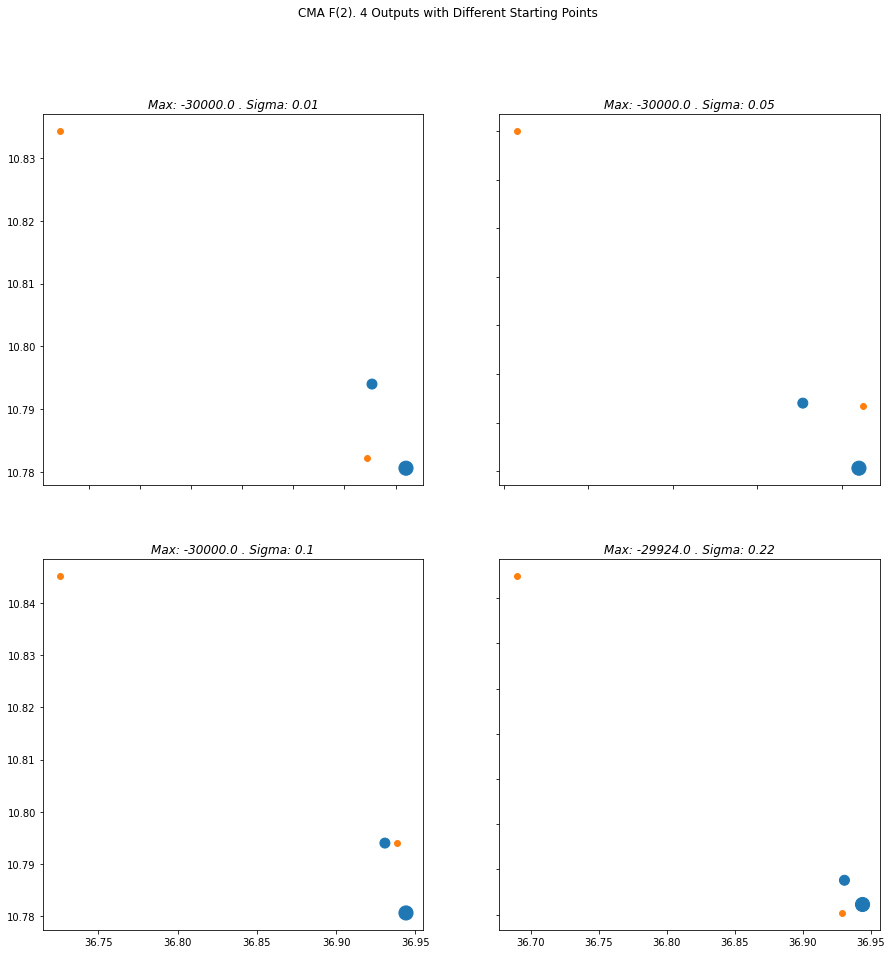

In [24]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('CMA F(2). 4 Outputs with Different Starting Points')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter(fcma2_s[i][1][1::2], fcma2_s[i][1][::2], s = 35, marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title('Max: ' + str(np.round(fcma2_s[i][0],0))+ ' . Sigma: ' + str(fcma2_s[i][2]), fontstyle='italic')

for ax in fig.get_axes():
    ax.label_outer()

In [100]:
chosenll = sorted(fcma2, key=lambda t: t[0])[:1]
chosenll = chosen[0][1]
chosenll = np.array(np.array_split(chosenll, proposed_schools))

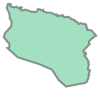

In [45]:
gdf_woreda_shp[0]

In [92]:
create_random_sp()

array([[10.93441251, 36.78691049],
       [10.77713938, 36.74052634]])

In [103]:
vec = gpd.points_from_xy(chosenll[:, 1], chosenll[:, 0])


array([ True,  True])

In [109]:
gdf_woreda['geometry'] # check all woredas and return corect. 

0      POLYGON ((42.79826 6.19605, 42.79808 6.19716, ...
1      POLYGON ((40.03742 13.56128, 40.03662 13.56091...
2      POLYGON ((37.39245 10.04636, 37.38730 10.04654...
3      POLYGON ((42.13371 9.32294, 42.13364 9.32295, ...
4      POLYGON ((37.43783 9.61581, 37.43800 9.61585, ...
                             ...                        
976    POLYGON ((37.53042 7.18994, 37.53009 7.19078, ...
977    POLYGON ((37.19295 6.44607, 37.19248 6.44601, ...
978    POLYGON ((38.93829 12.83392, 38.93804 12.83599...
979    POLYGON ((36.49363 10.70226, 36.49455 10.70188...
980    POLYGON ((39.09979 8.17049, 39.09723 8.17023, ...
Name: geometry, Length: 981, dtype: geometry

In [113]:
chosenll

array([[10.83427142, 36.80880804],
       [10.78217603, 36.92868157]])

In [ ]:
gdf_region = gpd.read_file('eth_shape_files/json//eth_admin1v2.json') # read in geojson
gdf_region_shp = gdf_region.loc[gdf_region['ADM1_EN']==region]['geometry'].reset_index(drop=True)

In [114]:
for i in chosenll:
    for j in gdf_region:
        vec.within(gdf_region['geometry'])
        
#     for j in gdf_woreda:
# for i in gdf_woreda:
    

# vec.within(gdf_woreda['geometry'])

NameError: name 'gdf_region' is not defined

In [99]:
check_woreda(chosenll)

True

array([10.83427142, 36.80880804])

In [80]:
chosenll

[array([10.83427142, 36.80880804]), array([10.78217603, 36.92868157])]

In [77]:
points = []
for i in chosenll:
    points += gpd.points_from_xy(i[0], i[1])

TypeError: len() of unsized object

[array([10.83427142, 36.80880804]), array([10.78217603, 36.92868157])]

In [60]:
chosenll[:1:2]

array([10.83427142])

In [47]:
dd = [gpd.points_from_xy(i[::2], i[1::2]) for i in chosen]
[i.within(gdf_woreda_shp[0]) for i in dd]

[False]

[array([10.83427142, 36.80880804]), array([10.78217603, 36.92868157])]

In [48]:
i

3

In [36]:
def get_location(vec):
    
    
    region
    zone
    woreda
    
    
    
    return 

array([10.83427142, 10.78217603])

In [ ]:
def check_woreda(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_woreda_shp[0]).all()
            
def check_region(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_region_shp[0]).all()

In [ ]:
# function to find region, zone and woreda of new school. 

,region,zone,woreda,school_name,school_code,geometry,lat,lon,gr_offer,urban_rural,...,ADM3_PCODE,ADM0_EN,ADM1_EN,ADM2_EN,ADM3_EN,point,nearest_up_prim,nearest_sch_code,nearest_lwr_sec,nearest_up_sec
0,Amhara,Agew awi,Ankesha,Buya,S0309030802,POINT (36.9441 10.7806),10.7806,36.9441,G.1-8,1,...,ET030908,Ethiopia,Amhara,Awi,Ayehu Guwagusa,"[10.7806, 36.9441]",NaN,S0309071703,6.420054,NaN
1,Amhara,Agew awi,Ankesha,Bosena Goashita,S0309031322,POINT (36.9308 10.794),10.7940,36.9308,G.1-8,1,...,ET030908,Ethiopia,Amhara,Awi,Ayehu Guwagusa,"[10.794, 36.9308]",NaN,S0309071703,7.282595,NaN
